# Predicting House Sale Prices

In this project, we're going to work with housing data for the city of Ames, Iowa US, from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables involved in assessing home values. We're going to use the linear regression model to predict the sale price. The data dictionary can be found on this [link](https://s3.amazonaws.com/dq-content/307/data_description.txt).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
import pylab
pd.options.display.max_columns = 999
from scipy.stats import skew
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_validate
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
houses = pd.concat([train,test], sort=False)
print(houses.shape)
houses.head()

(2919, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [3]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

The model we'll be using makes a good amount of [assumptions](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html) for the data:
1. Linearity: The relationship between X and the mean of Y is linear.
2. Homoscedasticity: The variance of residual (error) is the same for any value of X.
3. Independence: Observations are independent of each other.
4. Normality: For any fixed value of X, Y is normally distributed (Multivariate Normal).
5. Low or no Multicollinearity: The features are not too highly correlated with each other

Based on these assumptions, we'll need to transform or clean some columns throughout the project.

# Feature Engineering

### Handling missing values:

Let's check the missing values and thinking in strategies to deal with them.

In [4]:
all_miss = houses.isnull().sum()
percent_miss = (all_miss/houses.shape[0]) * 100
miss_table = pd.concat([all_miss, percent_miss], axis=1, keys=['Sum', 'Percent']).sort_values(by='Percent', ascending=False)
miss_table.head(40)

,Sum,Percent
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
SalePrice,1459,49.982871
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071


We'll delete variables with more than 5% missing data. Thus, `PoolQC`, `MiscFeature`, `Alley`, `Fence`, `FireplaceQu`, `LotFrontage`, `GarageType`, `GarageYrBlt`, `GarageFinish`, `GarageQual`, `GarageCond` will be deleted. Obviously, half of `SalePrice` column is missing because of the test set. Also, we'll not fill any value in there.

Regarding the following basement variables, `BsmtExposure`, `BsmtQual`, `BsmtCond`, `BsmtFinType1` and `BsmtFinType2`, we'll treat them more cautiously, because we'll check if their missing values if from some set of observation or it's all individually.

For the rest of the missing values, we'll substitute them with mode for categorical variables and median for continuous variable

In [5]:
cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
                'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond',]
houses = houses.drop(cols_to_drop, axis=1)

In [6]:
houses.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotArea            int64
Street            object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
                  ...   
Electrical        object
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64


In [7]:
cols_missing = houses.isnull().sum()[(houses.isnull().sum() > 0)].index
cols_missing

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
       'Functional', 'GarageCars', 'GarageArea', 'SaleType', 'SalePrice'],
      dtype='object')

In [8]:
cat_cols = houses[cols_missing].dtypes[houses[cols_missing].dtypes == 'object'].index
cat_cols = cat_cols.drop(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'])
num_cols = houses[cols_missing].dtypes[houses[cols_missing].dtypes == 'float'].index
num_cols = num_cols[num_cols != 'SalePrice']

In [9]:
houses[cat_cols] = houses[cat_cols].fillna(houses[cat_cols].mode().iloc[0])
houses[num_cols] = houses[num_cols].fillna(houses[num_cols].mean())
no_sale = houses.columns.drop(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'SalePrice'])
houses[no_sale].isnull().sum().max()

0

## Analysing the Target Column

Now, we'll explore our target column `SalePrice`, regarding its descriptive statistics and how much the features correlate with it. 

In [10]:
houses['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

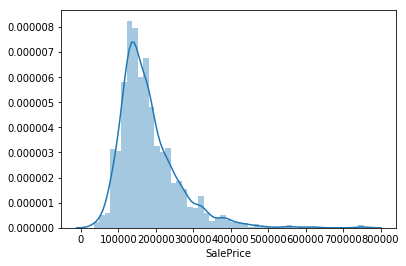

In [11]:
sns.distplot(houses['SalePrice'])

The above distribution plot for the `SalePrice` column is right skewed, so the modeling may not be useful for high price houses, since there will be many outliers. We'll treat them later.

Now, let's focus on the first assumption (Linearity) and the fifth one (Multicollinearity). We'll check which features are linearly strong correlated with the target column. As our first strategy, we'll consider only columns whose values are higher than 0.4 (or less than -0.4) correlated with `SalePrice`. Furthermore, let's check if among these features, there are ones that strongly correlate with each other, increasing overfitting. Let's see the heatmap of that.

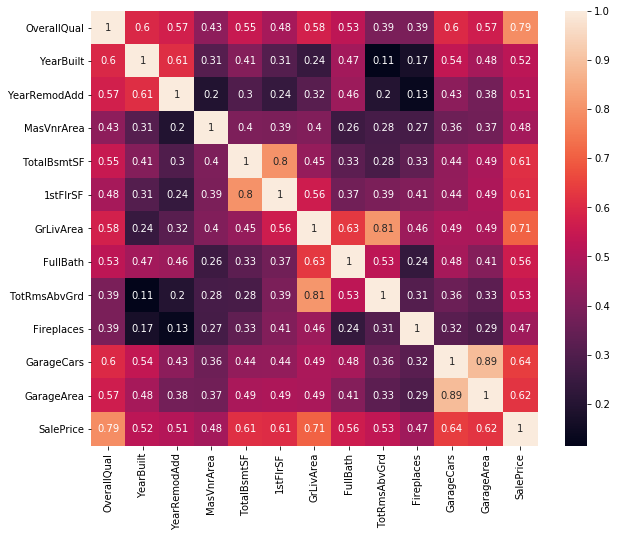

In [12]:
corrmat = houses.corr()
strong_corrs = corrmat.index[abs(corrmat['SalePrice'])>0.4]
plt.figure(figsize = (10, 8))
sns.heatmap(houses[strong_corrs].corr(), annot=True)
plt.show()

We can notice there are 13 features that strongly correlated with `SalePrice`, which `OverallQual`, `GrLivArea`, `GarageCars`/`GarageArea` and `TotalBsmtSF`/`1stFlrSF` stand out.

Observing the heatmap, we can see that the pairs below are strongly correlated with each other:
- `GrLivArea` and `TotRmsAbvGrd`;
- `GarageArea` and `GarageCars`;
- `1stFlrSF` and `TotalBsmtSF`

Looking at the data documentation, we can tell that each pair of columns reflects very similar information. Because `GrLivArea`, `GarageArea` are continuous variables that capture more nuance, let's drop the `TotRmsAbvGrd` and `GarageCars`. Also, we'll remove `1stFlrSF`, since `TotalBsmtSF` captures the whole basement area.

In [13]:
houses = houses.drop(['TotRmsAbvGrd', 'GarageCars', '1stFlrSF'], axis=1)
houses.shape

(2919, 67)

## Exploring Some of The Most Important Variables

Now, let's check some of the most important variables in order to get insight of the data and possibly eliminate some outliers.

### Overall Qual

Overall Quality has the highest correlation with SalePrice among the numeric variables (0.8). It rates the overall material and finish of the house on a scale from 1 (very poor) to 10 (very excellent).

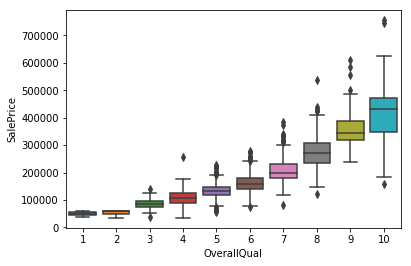

In [14]:
sns.boxplot(x = 'OverallQual', y='SalePrice', data=houses)
plt.show()

The positive correlation is certainly there indeed, and seems to be a slightly upward curve. Regarding outliers, we do not see any extreme values.

### Gr Liv Area

The numeric variable with the second highest correlation with SalesPrice is the Above Grade Living Area. This make a lot of sense; big houses are generally more expensive.

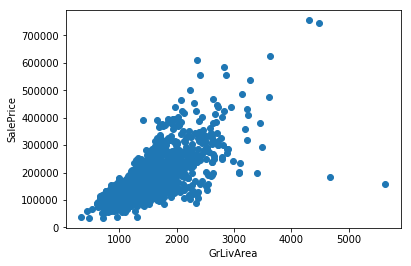

In [15]:
plt.scatter(x=houses['GrLivArea'], y=houses['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

Especially the two houses with really big living areas and low SalePrice seem extreme outliers (houses ID 524 and 1299). Taking out outliers can be dangerous. For instance, a low score on the Overall Quality could explain a low price. However, as you can see below, these two houses actually also score maximum points on Overall Quality. Therefore, we'll remove them as they can substantially increase error in our modeling.

In [16]:
houses[(houses['GrLivArea'] > 4000) & (houses['SalePrice'] < 230000)]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260.0,Unf,0.0,878.0,3138.0,GasA,Ex,Y,SBrkr,1538,0,4676,1.0,0.0,3,1,3,1,Ex,Typ,1,884.0,Y,208,406,0,0,0,0,0,10,2007,New,Partial,184750.0
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,950,0,5642,2.0,0.0,2,1,3,1,Ex,Typ,3,1418.0,Y,214,292,0,0,0,480,0,1,2008,New,Partial,160000.0


In [17]:
houses = houses[(houses['Id'] != 524) & (houses['Id'] != 1299)]
houses.shape

(2917, 67)

## Label Encoding and Factorizing Variables

Now that we dropped some extreme outliers and handled missing data, we'll follow to an extense part of the project. Let's analyze each character variable and convert them into ordinal integers if there is clear ordinality, or into factors if levels are categories without ordinality. Our strategy will be: if there is ordinality in the variable, we'll change it immediately, otherwise we'll treat the restant variables later.

Below, there are the columns with text values that we need to convert. Also, we have to be careful with number variables which represent categories. That's the case of the `Id` and `MSSubClass`. Thus, we'll analyze them as well.

In [18]:
houses.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

### 1. MSZoning

According to the data dictionary:

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

In [19]:
houses['MSZoning'].value_counts()

RL         2267
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

Apparently there is no sign of ordinality here, so we'll treat it as nominal.

### 2. MSSubclass

MS SubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

In [20]:
houses['MSSubClass'].value_counts()

20     1079
60      573
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

No ordinality here as well. However, we'll need to change the type of this column as it has integer values and it won't let the get_dummies function work to this feature.

In [21]:
houses['MSSubClass'] = houses['MSSubClass'].astype('object')
houses['MSSubClass'].dtype

dtype('O')

### 3. Street

Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved

In [22]:
houses['Street'].value_counts()

Pave    2905
Grvl      12
Name: Street, dtype: int64

It has ordinality (Pavement = best), so let's substitute it:

In [23]:
map_street = {'Grvl': 0, 'Pave': 1}
houses['Street'] = houses['Street'].replace(map_street)

### 4. LotShape

Lot Shape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

In [24]:
houses['LotShape'].value_counts()

Reg    1859
IR1     967
IR2      76
IR3      15
Name: LotShape, dtype: int64

It has ordinality (Regular = best), so let's substitute it:

In [25]:
map_lotshape = {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}
houses['LotShape'] = houses['LotShape'].replace(map_lotshape)

### 5. LotConfig

Lot Config: Lot configuration
       
       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

In [26]:
houses['LotConfig'].value_counts()

Inside     2132
Corner      510
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

Let's plot this to understand if it has ordinality.

<BarContainer object of 5 artists>

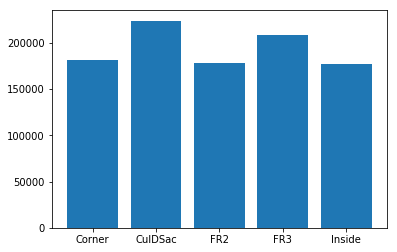

In [27]:
plt.bar(houses.groupby('LotConfig')['SalePrice'].mean().index, houses.groupby('LotConfig')['SalePrice'].mean())

It doesn't see to have ordinality. We'll convert it into a factor later on.

### 6. LandContour

Land Contour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression

In [28]:
houses['LandContour'].value_counts()

Lvl    2622
HLS     120
Bnk     115
Low      60
Name: LandContour, dtype: int64

Let's plot this to understand if we can consider ordinality.

<BarContainer object of 4 artists>

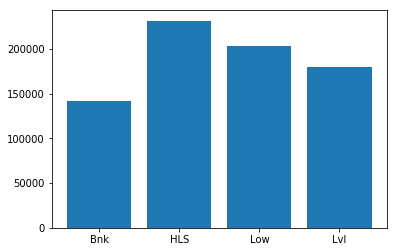

In [29]:
plt.bar(houses.groupby('LandContour')['SalePrice'].mean().index, houses.groupby('LandContour')['SalePrice'].mean())

We'll consider ordinality on that. So, let's substitute considering the bar plot:

In [30]:
map_landcontour = {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}
houses['LandContour'] = houses['LandContour'].replace(map_landcontour)

### 7. LandSlope

Land Slope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

In [31]:
houses['LandSlope'].value_counts()

Gtl    2776
Mod     125
Sev      16
Name: LandSlope, dtype: int64

It has ordinality (Gentle = best), so let's substitute it:

In [32]:
map_landslope = {'Sev': 0, 'Mod': 1, 'Gtl': 2}
houses['LandSlope'] = houses['LandSlope'].replace(map_landslope)

### 8. Utilities

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

In [33]:
houses['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

Only one house doesn't have all the public utilities. Since there is no variance at all in this column, we'll drop it.

In [34]:
houses = houses.drop('Utilities', axis=1)
houses.shape

(2917, 66)

### 9. Neighborhood

Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

In [35]:
houses['Neighborhood'].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    192
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64

In order to understand if there is any ordinality, we'll plot two graphs: Median SalePrice x Neighborhood and Mean SalePrice x Neighborhood. The point is to check if there are groups of neighborhoods with an average sale price higher or lower than others.

In [36]:
median_table = pd.DataFrame(houses.groupby('Neighborhood')['SalePrice'].median()).sort_values(by='SalePrice')
mean_table = pd.DataFrame(houses.groupby('Neighborhood')['SalePrice'].mean()).sort_values(by='SalePrice')

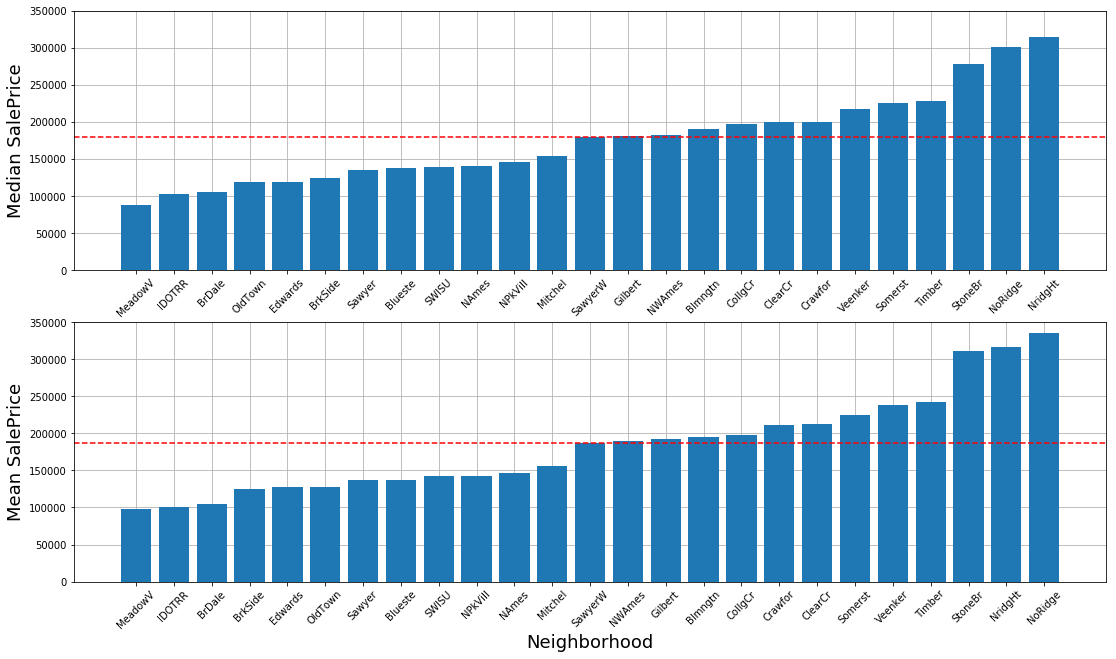

In [37]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(18.5, 10.5)

ax1.grid(zorder=0)
ax1.bar(median_table.index, median_table['SalePrice'], zorder=2)
ax1.set_ylabel("Median SalePrice", fontsize=18)
ax1.set_ylim(0, 350000)
ax1.axhline(median_table['SalePrice'].median(), c='red', ls='--')
ax1.set_xticklabels(median_table.index, rotation = 45)

ax2.grid(zorder=0)
ax2.bar(mean_table.index, mean_table['SalePrice'], zorder=2)
ax2.set_xlabel("Neighborhood", fontsize=18)
ax2.set_ylabel("Mean SalePrice", fontsize=18)
ax2.set_ylim(0, 350000)
ax2.axhline(mean_table['SalePrice'].median(), c='red', ls='--')
ax2.set_xticklabels(mean_table.index, rotation = 45)

plt.show()

Both the median and mean Saleprices indicate 3 neighborhoods with substantially higher saleprices (StoneBr, NoRidge and NridgHt). In contrast, we can notice 3 neighborhoods with lower saleprices in both graphs (MeadowV, IDOTRR and BrDale). Despite it's not so clear what happens in the middle, we can notice 2 major groups: those neighborhoods with saleprices less than the median/mean, but higher than those 3 poor neighborhoods; and the group with saleprices greater or (roughly) equal to median/mean, but lower than those 3 rich neighborhoods.
Therefore, let's consider 4 main groups as ordinality criteria and substitute their values:

In [38]:
group1 = ['MeadowV', 'IDOTRR', 'BrDale']
group2 = ['BrkSide', 'Edwards', 'OldTown', 'Sawyer', 'Blueste', 'SWISU', 'NPkVill', 'NAmes', 'Mitchel']
group3 = ['SawyerW', 'NWAmes', 'Gilbert', 'Blmngtn', 'CollgCr', 'Crawfor', 'ClearCr', 'Somerst', 'Veenker', 'Timber']
group4 = ['StoneBr', 'NridgHt', 'NoRidge']
map_neighbor = {}
for a in group1:
    map_neighbor[a] = 0
for b in group2:
    map_neighbor[b] = 1
for c in group3:
    map_neighbor[c] = 2
for d in group4:
    map_neighbor[d] = 3

houses['Neighborhood'] = houses['Neighborhood'].replace(map_neighbor)

### 10./11. Condition1 and Condition2

They both mean the same feature, but Condition2 indicates the presence of more than 1 condition.

Condition1 and Condition 2: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

In [39]:
houses['Condition1'].value_counts()

Norm      2511
Feedr      163
Artery      92
RRAn        50
PosN        38
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64

In [40]:
houses['Condition2'].value_counts()

Norm      2888
Feedr       13
Artery       5
PosA         4
PosN         3
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

There is no ordinality in these variables, so we'll factorize them later

### 12. Bldg Type

BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

In [41]:
houses['BldgType'].value_counts()

1Fam      2423
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64

Apparently, there is no ordinality in this variable. We'll convert it later.

### 13. HouseStyle

House Style: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

In [42]:
houses['HouseStyle'].value_counts()

1Story    1471
2Story     870
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64

No ordinality, so we'll convert it into factors

### 14. RoofStyle

Roof Style: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed

In [43]:
houses['RoofStyle'].value_counts()

Gable      2310
Hip         549
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64

No ordinality, so we'll convert it into factors

### 15. RoofMatl

Roof Matl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

In [44]:
houses['RoofMatl'].value_counts()

CompShg    2875
Tar&Grv      23
WdShake       9
WdShngl       7
Membran       1
Metal         1
Roll          1
Name: RoofMatl, dtype: int64

No ordinality, so we'll convert it into factors

### 16./17. Exterior1st and Exterior2nd

Similarly to conditions (see 10./11.)
Exterior 1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

In [45]:
houses['Exterior1st'].value_counts()

VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
CBlock        2
Stone         2
AsphShn       2
ImStucc       1
Name: Exterior1st, dtype: int64

In [46]:
houses['Exterior2nd'].value_counts()

VinylSd    1015
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

There is no apparently ordinality on both. We'll convert them into factors

### 18. ExterQual

Exter Qual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

In [47]:
houses['ExterQual'].value_counts()

TA    1798
Gd     979
Ex     105
Fa      35
Name: ExterQual, dtype: int64

There is ordinality in this variable. So, we'll transform it:

In [48]:
map_exterqual = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
houses['ExterQual'] = houses['ExterQual'].replace(map_exterqual)

### 19. ExterCond

Exter Cond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

In [49]:
houses['ExterCond'].value_counts()

TA    2536
Gd     299
Fa      67
Ex      12
Po       3
Name: ExterCond, dtype: int64

Like `ExterQual` there is ordinality in this column.

In [50]:
map_extercond = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
houses['ExterCond'] = houses['ExterCond'].replace(map_extercond)

### 20. MasVnrType

Mas Vnr Type: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

In [51]:
houses['MasVnrType'].value_counts()

None       1766
BrkFace     879
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64

<BarContainer object of 4 artists>

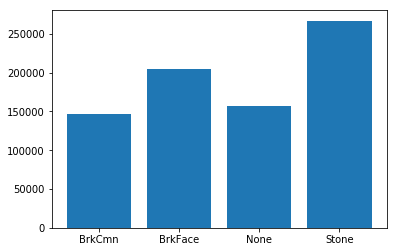

In [52]:
plt.bar(houses.groupby('MasVnrType')['SalePrice'].mean().index, houses.groupby('MasVnrType')['SalePrice'].mean())

Looking at the variable values we can notice that there is ordinality on data. However, plotting them and comparing their mean values to Saleprice, apparently there is no significative difference between BrkCmn and None. So, we'll generate the values according to these proportions.

In [53]:
map_masvnrtype = {'None': 0, 'BrkCmn': 0, 'BrkFace': 1, 'Stone': 2}
houses['MasVnrType'] = houses['MasVnrType'].replace(map_masvnrtype)

### 21. Foundation

Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

In [54]:
houses['Foundation'].value_counts()

PConc     1306
CBlock    1235
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: Foundation, dtype: int64

Let's check if there is ordinality on this feature.

<BarContainer object of 6 artists>

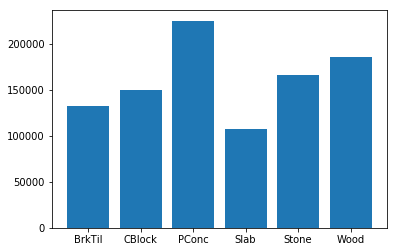

In [55]:
plt.bar(houses.groupby('Foundation')['SalePrice'].mean().index, houses.groupby('Foundation')['SalePrice'].mean())

It seems there is a crescent here, however it's good to put Stone and Wood together as they have few values to really distinguish themselves looking at the mean saleprice. Therefore, let's consider this ordinality.

In [56]:
map_foundation = {'Slab': 1, 'BrkTil': 2, 'CBlock': 3, 'Stone': 4, 'Wood': 4, 'PConc': 5}
houses['Foundation'] = houses['Foundation'].replace(map_foundation)

### 22. Heating

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace

In [57]:
houses['Heating'].value_counts()

GasA     2872
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

The values don't seem to show any ordinality and there is a low count on various unique values (Grav, Wall, OthW and Floow) to comprove any significative difference. So, we'll transform them to factors later on.

### 23. HeatingQC

Heating QC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

In [58]:
houses['HeatingQC'].value_counts()

Ex    1491
TA     857
Gd     474
Fa      92
Po       3
Name: HeatingQC, dtype: int64

It seems to have ordinality, so we'll transform it:

In [59]:
map_heatqc = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
houses['HeatingQC'] = houses['HeatingQC'].replace(map_heatqc)

### 24. Central Air

Central Air: Central air conditioning

       N	No
       Y	Yes

In [60]:
houses['CentralAir'].value_counts()

Y    2721
N     196
Name: CentralAir, dtype: int64

Since it's a binary classification, let's convert it:

In [61]:
map_centralair = {'N': 0, 'Y': 1}
houses['CentralAir'] = houses['CentralAir'].replace(map_centralair)

### 25. Electrical

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [62]:
houses['Electrical'].value_counts()

SBrkr    2670
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

Let's check if there is ordinality on this feature

<BarContainer object of 5 artists>

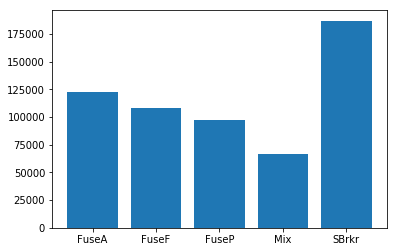

In [63]:
plt.bar(houses.groupby('Electrical')['SalePrice'].mean().index, houses.groupby('Electrical')['SalePrice'].mean())

It seems to have ordinality, so we'll transform it. As we have only 1 value of Mix, we'll put it together with FuseP in the classification

In [64]:
map_electrical = {'Mix': 1, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr': 4}
houses['Electrical'] = houses['Electrical'].replace(map_electrical)

### 26. KitchenQual

Kitchen Qual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

In [65]:
houses['KitchenQual'].value_counts()

TA    1493
Gd    1151
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

Like the ones we saw before, let's convert it:

In [66]:
map_kitqual = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
houses['KitchenQual'] = houses['KitchenQual'].replace(map_kitqual)

### 27. Functional

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

In [67]:
houses['Functional'].value_counts()

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

It can be made ordinal (salvage only is worst, typical is best)

In [68]:
map_functional = {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}
houses['Functional'] = houses['Functional'].replace(map_functional)

### 28. PavedDrive

Paved Drive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

In [69]:
houses['PavedDrive'].value_counts()

Y    2639
N     216
P      62
Name: PavedDrive, dtype: int64

Similarly like we did with `Street`, let's convert it:

In [70]:
map_paved = {'N': 0, 'P': 1, 'Y': 2}
houses['PavedDrive'] = houses['PavedDrive'].replace(map_paved)

### 29. SaleType

Sale Type: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

In [71]:
houses['SaleType'].value_counts()

WD       2526
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

It doesn't seem to have ordinality, so we'll treat it later

### 30. SaleCondition

Sale Condition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

In [72]:
houses['SaleCondition'].value_counts()

Normal     2402
Partial     243
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: SaleCondition, dtype: int64

It also doesn't seem to have any ordinality. Let's treat it later.

### Basement Variables

Now that we have seen all the other categorical variables, let's look closer to the basement variables. Let's start by look how many missing values are from the same set of observations.

In [73]:
houses[(houses['BsmtExposure']).isnull() & (houses['BsmtQual']).isnull() & (houses['BsmtCond']).isnull() & 
       (houses['BsmtFinType1']).isnull() & (houses['BsmtFinType2']).isnull()].shape[0]

79

Let's take a look in the remaining rows containing at least 1 missing value in at least one of these columns.

In [74]:
no_bsmt = houses[(houses['BsmtFinType1'].notnull()) & ((houses['BsmtExposure']).isnull() | (houses['BsmtQual']).isnull()
        | (houses['BsmtCond']).isnull() | (houses['BsmtFinType2']).isnull())]
no_bsmt

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,333,20,RL,10655,1,2,1,Inside,2,3,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,1,296.0,4,3,5,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,GasA,5,1,4,0,0,1629,1.0,0.0,2,0,3,1,4,7,1,880.0,2,0,0,0,0,0,0,0,10,2009,WD,Normal,284000.0
948,949,60,RL,14006,1,2,1,Inside,2,2,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,1,144.0,4,3,5,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,GasA,5,1,4,840,0,1776,0.0,0.0,2,1,3,1,4,7,1,474.0,2,144,96,0,0,0,0,0,2,2006,WD,Normal,192500.0
27,1488,20,RL,8987,1,3,1,Inside,2,2,Norm,Norm,1Fam,1Story,8,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,1,226.0,4,3,5,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,GasA,5,1,4,0,0,1595,0.0,0.0,2,0,2,1,4,7,1,880.0,2,144,0,0,0,0,0,0,5,2010,WD,Normal,NaN
580,2041,20,RL,16280,1,3,1,Inside,2,2,Norm,Norm,1Fam,1Story,8,9,1976,2007,Gable,CompShg,VinylSd,VinylSd,0,0.0,5,5,3,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,GasA,5,1,4,0,0,1671,1.0,0.0,3,0,3,1,5,7,1,550.0,2,280,90,0,0,0,0,0,5,2008,WD,Normal,NaN
725,2186,20,RL,6500,1,3,1,Inside,2,1,Norm,Norm,1Fam,1Story,6,6,1976,1976,Hip,CompShg,HdBoard,Plywood,1,84.0,3,3,3,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,GasA,3,1,4,0,0,1127,0.0,1.0,1,1,3,1,3,7,1,480.0,2,0,0,138,0,0,0,0,5,2008,WD,Normal,NaN
757,2218,70,C (all),5280,1,3,1,Corner,2,0,Feedr,Norm,1Fam,2Story,4,7,1895,1950,Gable,CompShg,Wd Sdng,Wd Sdng,0,0.0,3,3,4,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA,5,0,4,536,0,1361,0.0,0.0,1,0,2,1,3,7,0,185.0,2,0,123,0,0,0,0,0,7,2008,WD,Normal,NaN
758,2219,50,C (all),5150,1,3,1,Corner,2,0,Feedr,Norm,1Fam,1.5Fin,4,7,1910,2000,Gable,CompShg,Plywood,Plywood,0,0.0,3,3,5,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA,3,0,3,378,0,1049,0.0,0.0,1,0,2,1,3,7,0,195.0,0,0,0,0,0,0,0,0,5,2008,WD,Normal,NaN
888,2349,60,FV,10411,1,3,1,Corner,2,2,Norm,Norm,1Fam,2Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,0,0.0,4,3,3,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,GasA,5,1,4,863,0,1588,0.0,0.0,3,0,3,1,4,7,0,561.0,2,0,0,0,0,0,0,0,7,2007,New,Partial,NaN
1064,2525,80,RL,9720,1,3,1,Inside,2,2,Norm,Norm,1Fam,SLvl,5,7,1977,1977,Gable,CompShg,Plywood,VinylSd,1,51.0,3,3,3,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,GasA,3,1,4,0,0,1009,0.0,0.0,2,0,3,1,3,7,1,576.0,2,0,0,0,0,0,0,0,6,2007,WD,Normal,NaN


It seems there are 79 observations with all these variables containing missing values, i.e., these houses don't have a basement. So, we'll keep the missing values in there and anticipating what we'll do next, all these variables have ordinality, so we'll substitute the NA values for 0 when we convert them. 

For the remaining 9 houses, we'll substitute the missing values for the mode of each respective column.

In [75]:
houses.iloc[[332, 947, 1485, 2038, 2183, 2215, 2216, 2346, 2522], [27, 28, 29, 30, 32]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
332,Gd,TA,No,GLQ,NaN
948,Gd,TA,NaN,Unf,Unf
27,Gd,TA,NaN,Unf,Unf
580,Gd,NaN,Mn,GLQ,Rec
725,TA,NaN,No,BLQ,Unf
757,NaN,Fa,No,Unf,Unf
758,NaN,TA,No,Unf,Unf
888,Gd,TA,NaN,Unf,Unf
1064,TA,NaN,Av,ALQ,Unf


In [76]:
houses.iloc[[332, 947, 1485, 2038, 2183, 2215, 2216, 2346, 2522], [27, 28, 29, 30, 32]] = houses.iloc[
    [332, 947, 1485, 2038, 2183, 2215, 2216, 2346, 2522], [27, 28, 29, 30, 32]].fillna(
    houses[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].mode().iloc[0])

In [77]:
houses.iloc[[332, 947, 1485, 2038, 2183, 2215, 2216, 2346, 2522], [27, 28, 29, 30, 32]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
332,Gd,TA,No,GLQ,Unf
948,Gd,TA,No,Unf,Unf
27,Gd,TA,No,Unf,Unf
580,Gd,TA,Mn,GLQ,Rec
725,TA,TA,No,BLQ,Unf
757,TA,Fa,No,Unf,Unf
758,TA,TA,No,Unf,Unf
888,Gd,TA,No,Unf,Unf
1064,TA,TA,Av,ALQ,Unf


### 31. BsmtQual

Bsmt Qual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches)
       NA	No Basement

In [78]:
houses['BsmtQual'].value_counts(dropna=False)

TA     1285
Gd     1209
Ex      256
Fa       88
NaN      79
Name: BsmtQual, dtype: int64

Like the ones we saw before, there is ordinality on the values. We'll convert it:

In [79]:
map_bsmtqual = {np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
houses['BsmtQual'] = houses['BsmtQual'].replace(map_bsmtqual)

### 32. Bsmt Cond

Bsmt Cond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

In [80]:
houses['BsmtCond'].value_counts(dropna=False)

TA     2607
Gd      122
Fa      104
NaN      79
Po        5
Name: BsmtCond, dtype: int64

Same as the previously one. Let's convert it.

In [81]:
map_bsmtcond = {np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
houses['BsmtCond'] = houses['BsmtCond'].replace(map_bsmtcond)

### 33. Bsmt Exposure

Bsmt Exposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

There is ordinality on this data, so we'll convert it

In [82]:
houses['BsmtExposure'].value_counts(dropna=False)

No     1907
Av      418
Gd      274
Mn      239
NaN      79
Name: BsmtExposure, dtype: int64

In [83]:
map_bsmtexp = {np.nan: 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4,}
houses['BsmtExposure'] = houses['BsmtExposure'].replace(map_bsmtexp)

### 34./35. Bsmt Fin Type 1 and Type 2

Both variables have the same classification, so we'll substitute them both.

BsmtFin Type 1: Rating of basement finished area (BsmtFinType 2 if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

In [84]:
houses['BsmtFinType1'].value_counts(dropna=False)

Unf    851
GLQ    847
ALQ    429
Rec    288
BLQ    269
LwQ    154
NaN     79
Name: BsmtFinType1, dtype: int64

In [85]:
houses['BsmtFinType2'].value_counts(dropna=False)

Unf    2492
Rec     105
LwQ      87
NaN      79
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64

There is ordinality, so we'll convert it.

In [86]:
map_bsmtfin = {np.nan: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
houses['BsmtFinType1'] = houses['BsmtFinType1'].replace(map_bsmtfin)
houses['BsmtFinType2'] = houses['BsmtFinType2'].replace(map_bsmtfin)

## Getting Dummies

Now that we look all the character variables one by one, let's factorize those which don't have ordinality.

In [87]:
# Selecting the columns to factorize
cols_to_factorize = ['MSZoning', 'MSSubClass', 'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
                     'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Heating', 'SaleType', 'SaleCondition']
# Creating the dummy variables
houses_factorized = pd.get_dummies(houses[cols_to_factorize])

In [88]:
# Concatenating both houses and the dummy variables and drop the old columns
houses = pd.concat([houses, houses_factorized], axis=1)
houses = houses.drop(cols_to_factorize, axis=1)

In [89]:
houses.shape

(2917, 173)

In [90]:
houses.head()

,Id,LotArea,Street,LotShape,LandContour,LandSlope,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,8450,1,3,1,2,2,7,5,2003,2003,1,196.0,4,3,5,4,3,1,6,706.0,1,0.0,150.0,856.0,5,1,4,854,0,1710,1.0,0.0,2,1,3,1,4,7,0,548.0,2,0,61,0,0,0,0,0,2,2008,208500.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,9600,1,3,1,2,2,6,8,1976,1976,0,0.0,3,3,3,4,3,4,5,978.0,1,0.0,284.0,1262.0,5,1,4,0,0,1262,0.0,1.0,2,0,3,1,3,7,1,460.0,2,298,0,0,0,0,0,0,5,2007,181500.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3,11250,1,2,1,2,2,7,5,2001,2002,1,162.0,4,3,5,4,3,2,6,486.0,1,0.0,434.0,920.0,5,1,4,866,0,1786,1.0,0.0,2,1,3,1,4,7,1,608.0,2,0,42,0,0,0,0,0,9,2008,223500.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4,9550,1,2,1,2,2,7,5,1915,1970,0,0.0,3,3,2,3,4,1,5,216.0,1,0.0,540.0,756.0,4,1,4,756,0,1717,1.0,0.0,1,0,3,1,4,7,1,642.0,2,0,35,272,0,0,0,0,2,2006,140000.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

## Time Variables

Now, we'll lead with the variables that involves time, i.e., `MoSold`, `YrSold`, `YearBuilt` and `YearRemodAdd`

### Year Sold and Month Sold
Starting with Month Sold, it's a integer variable, however there isn't a month "better" or "worse" than other. To confirm that, let's plot a graph:

In [91]:
houses['MoSold'].value_counts()

6     503
7     446
5     394
4     279
8     233
3     232
10    172
9     158
11    142
2     133
1     121
12    104
Name: MoSold, dtype: int64

<BarContainer object of 12 artists>

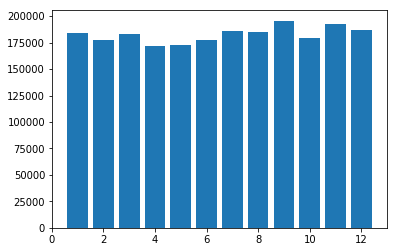

In [92]:
plt.bar(houses.groupby('MoSold')['SalePrice'].mean().index, houses.groupby('MoSold')['SalePrice'].mean())

As we can see, it doesn't seem to have ordinality, neither seasonality. Thus, we'll convert this into factors later.

Now, we move on to YearSold. We can think the houses are sold for higher prices throughout the years. Let's also check this by graph.

<BarContainer object of 5 artists>

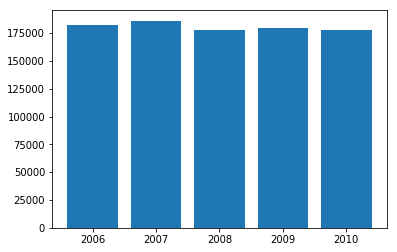

In [93]:
plt.bar(houses.groupby('YrSold')['SalePrice'].mean().index, houses.groupby('YrSold')['SalePrice'].mean())

The graph doesn't confirm our assumption. Instead, the prices fall in 2008 and probably it could be related to the Banking Crisis. As we can't see ordinality, we'll convert this variable in factors as well.

### Creating New Variables: 'HouseAge', 'Remodeled', 'IsNew'

Altogether, there are 3 variables that are relevant with regards to the Age of a house; YearBlt, YearRemodAdd, and YearSold. YearRemodAdd defaults to YearBuilt if there has been no Remodeling/Addition. We will use YearRemodeled and YearSold to determine the Age. However, as parts of old constructions will always remain and only parts of the house might have been renovated, we will also introduce a Remodeled Yes/No variable. This should be seen as some sort of penalty parameter that indicates that if the Age is based on a remodeling date, it is probably worth less than houses that were built from scratch in that same year.

In [94]:
houses['HouseAge'] = houses['YrSold'] - houses['YearRemodAdd']
houses['HouseAge'].value_counts().sort_index()

-2       1
-1       1
 0     237
 1     193
 2     104
 3      97
 4     111
 5      91
 6      83
 7      75
 8      85
 9      69
 10     66
 11     62
 12     58
 13     57
 14     46
 15     37
 16     38
 17     33
 18     18
 19     21
 20     17
 21     15
 22     13
 23     18
 24     10
 25     14
 26     14
 27     18
      ... 
 31     50
 32     36
 33     29
 34     30
 35     22
 36     37
 37     30
 38     27
 39     47
 40     30
 41     26
 42     33
 43     27
 44     34
 45     22
 46     25
 47     28
 48     26
 49     27
 50     23
 51     31
 52     29
 53     30
 54     21
 55     23
 56    112
 57     79
 58     76
 59     78
 60     42
Name: HouseAge, Length: 63, dtype: int64

It seems there are two houses with negative ages. Let's check this out.

In [95]:
houses[houses['HouseAge'] < 0]

,Id,LotArea,Street,LotShape,LandContour,LandSlope,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HouseAge
835,2296,16659,1,2,1,2,3,8,5,2007,2008,0,0.0,4,3,5,4,3,1,1,0.0,1,0.0,1582.0,1582.0,5,1,4,570,0,2152,0.0,0.0,2,1,3,1,4,7,1,728.0,2,0,368,0,0,0,0,0,6,2007,NaN,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,-1
1089,2550,39290,1,2,0,2,1,10,5,2008,2009,2,1224.0,5,3,5,5,3,4,6,4010.0,1,0.0,1085.0,5095.0,5,1,4,0,0,5095,1.0,1.0,2,1,2,1,5,7,2,1154.0,2,546,484,0,0,0,0,17000,10,2007,NaN,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,-2


Even though there are two houses with negative ages, we'll just keep it because it won't interfer that much in the correlation.

Now, let's plot the graph vs. SalePrice and calculate the correlation between them.

-0.5097057958391056


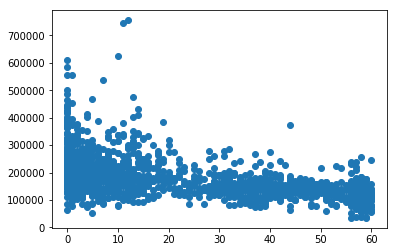

In [96]:
print(houses['HouseAge'].corr(houses['SalePrice']))
plt.scatter(houses['HouseAge'], houses['SalePrice'])
plt.show()

As expected, the graph shows a negative correlation with HouseAge (old house are worth less).

In [97]:
houses['Remodeled'] = (houses['YearBuilt'] == houses['YearRemodAdd']).astype('int')
houses['Remodeled'].value_counts()

1    1559
0    1358
Name: Remodeled, dtype: int64

Now, we'll create the IsNew variable, where it will be 1 if the same year the house was built also it was sold.

In [98]:
houses['IsNew'] = (houses['YearBuilt'] == houses['YrSold']).astype('int')
houses['IsNew'].value_counts()

0    2803
1     114
Name: IsNew, dtype: int64

We need to convert `YrSold` and `MoSold` into factors:

In [99]:
# First we need to convert YrSold and MoSold to object type, as we did before
houses[['YrSold', 'MoSold']] = houses[['YrSold', 'MoSold']].astype('object')
sold_feat = pd.get_dummies(houses[['YrSold', 'MoSold']])
houses = pd.concat([houses, sold_feat], axis=1)
houses = houses.drop(['YrSold', 'MoSold'], axis=1)
houses.head()

,Id,LotArea,Street,LotShape,LandContour,LandSlope,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HouseAge,Remodeled,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12
0,1,8450,1,3,1,2,2,7,5,2003,2003,1,196.0,4,3,5,4,3,1,6,706.0,1,0.0,150.0,856.0,5,1,4,854,0,1710,1.0,0.0,2,1,3,1,4,7,0,548.0,2,0,61,0,0,0,0,0,208500.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,5,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,9600,1,3,1,2,2,6,8,1976,1976,0,0.0,3,3,3,4,3,4,5,978.0,1,0.0,284.0,1262.0,5,1,4,0,0,1262,0.0,1.0,2,0,3,1,3,7,1,460.0,2,298,0,0,0,0,0,0,181500.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,31,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,3,11250,1,2,1,2,2,7,5,2001,2002,1,162.0,4,3,5,4,3,2,6,486.0,1,0.0,434.0,920.0,5,1,4,866,0,1786,1.0,0.0,2,1,3,1,4,7,1,608.0,2,0,42,0,0,0,0,0,223500.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1

In [100]:
houses.shape

(2917, 191)

## Bath Variables

There are 4 bathroom variables, `FullBath`, `HalfBath`, `BsmtFullBath` and `BsmtHalfBath`. Individually, these variables are not very important. However, we assume that if we add them up into one predictor, this predictor is likely to become a strong one.

“A half-bath, also known as a powder room or guest bath, has only two of the four main bathroom components-typically a toilet and sink.” Consequently, we will also count the half bathrooms as half.

In [101]:
houses['TotalBathrooms'] = houses['FullBath'] + 0.5*houses['HalfBath'] + houses['BsmtFullBath'] + 0.5*houses['BsmtHalfBath']
houses.head(3)

,Id,LotArea,Street,LotShape,LandContour,LandSlope,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HouseAge,Remodeled,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalBathrooms
0,1,8450,1,3,1,2,2,7,5,2003,2003,1,196.0,4,3,5,4,3,1,6,706.0,1,0.0,150.0,856.0,5,1,4,854,0,1710,1.0,0.0,2,1,3,1,4,7,0,548.0,2,0,61,0,0,0,0,0,208500.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,5,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.5
1,2,9600,1,3,1,2,2,6,8,1976,1976,0,0.0,3,3,3,4,3,4,5,978.0,1,0.0,284.0,1262.0,5,1,4,0,0,1262,0.0,1.0,2,0,3,1,3,7,1,460.0,2,298,0,0,0,0,0,0,181500.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,31,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2.5
2,3,11250,1,2,1,2,2,7,5,2001,2002,1,162.0,4,3,5,4,3,2,6,486.0,1,0.0,434.0,920.0,5,1,4,866,0,1786,1.0,0.0,2,1,3,1,4,7,1,608.0,2,0,42,0,0,0,0,0,223500.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,

Let's check its correlation with SalePrice and see the graph.

In [102]:
houses.iloc[:1458, [-1,49]]

,TotalBathrooms,SalePrice
0,3.5,208500.0
1,2.5,181500.0
2,3.5,223500.0
3,2.0,140000.0
4,3.5,250000.0
5,2.5,143000.0
6,3.0,307000.0
7,3.5,200000.0
8,2.0,129900.0
9,2.0,118000.0


Correlation between TotalBathrooms and SalePrice:0.6358962975612403


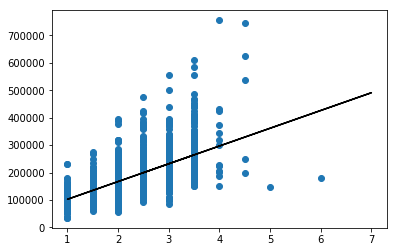

In [103]:
m, b = np.polyfit(houses.iloc[:1458, -1], houses.iloc[:1458, 49], 1)
print('Correlation between TotalBathrooms and SalePrice:' + str(houses['TotalBathrooms'].corr(houses['SalePrice'])))
plt.scatter(houses['TotalBathrooms'], houses['SalePrice'])
plt.plot(houses['TotalBathrooms'], m*(houses['TotalBathrooms'])+b, c='black')
plt.show()

Now, there seems to be a clear correlation (0.63) and the graph shows us its ascending.

## Total Square Feet

As the total living space generally is very important when people buy houses, we are adding a predictors that adds up the living space above and below ground.

In [104]:
houses['TotalSqFeet'] = houses['GrLivArea'] + houses['TotalBsmtSF']
houses[['GrLivArea', 'TotalBsmtSF', 'TotalSqFeet']].head(3)

,GrLivArea,TotalBsmtSF,TotalSqFeet
0,1710,856.0,2566.0
1,1262,1262.0,2524.0
2,1786,920.0,2706.0


Correlation between TotalSqFeet and SalePrice: 0.8290419781065514


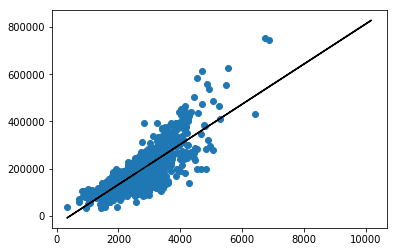

In [105]:
m, b = np.polyfit(houses.iloc[:1458, -1], houses.iloc[:1458, 49], 1)
print('Correlation between TotalSqFeet and SalePrice: ' + str(houses['TotalSqFeet'].corr(houses['SalePrice'])))
plt.scatter(houses['TotalSqFeet'], houses['SalePrice'])
plt.plot(houses['TotalSqFeet'], m*(houses['TotalSqFeet'])+b, c='black')
plt.show()

As we expected, the `TotalSqFeet` is strongly correlated with SalePrice (0.83)

## Final Preparations for Modeling

### Checking Correlations After All Changes

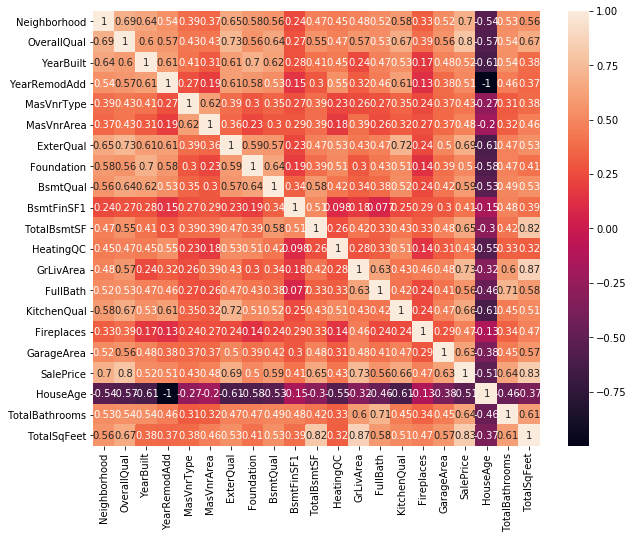

In [106]:
corrmat_2 = houses.corr()
strong_corrs_2 = corrmat_2.index[abs(corrmat_2['SalePrice'])>0.4]
plt.figure(figsize = (10, 8))
sns.heatmap(houses[strong_corrs_2].corr(), annot=True)
plt.show()

We can see above that we have increased the number of variables with a correlation of at least 0.4 with the `SalePrice` from 12 to 19.

### Dropping highly correlated features

Again, based on the fifth assumption (multicollinearity) like we did before, we'll drop columns highly correlated with each other.

In [107]:
corrs = houses.corr()[abs(houses.corr()) > 0.8]
np.fill_diagonal(corrs.values, np.nan)
corrs.stack()

YearRemodAdd           HouseAge                -0.998018
BsmtFinType2           BsmtFinSF2               0.800308
BsmtFinSF2             BsmtFinType2             0.800308
TotalBsmtSF            TotalSqFeet              0.817057
2ndFlrSF               HouseStyle_2Story        0.810063
GrLivArea              TotalSqFeet              0.867291
SalePrice              TotalSqFeet              0.829042
MSZoning_RL            MSZoning_RM             -0.808063
MSZoning_RM            MSZoning_RL             -0.808063
MSSubClass_45          HouseStyle_1.5Unf        0.864323
MSSubClass_50          HouseStyle_1.5Fin        0.932551
MSSubClass_80          HouseStyle_SLvl          0.958427
MSSubClass_90          BldgType_Duplex          1.000000
MSSubClass_190         BldgType_2fmCon          0.975118
BldgType_2fmCon        MSSubClass_190           0.975118
BldgType_Duplex        MSSubClass_90            1.000000
HouseStyle_1.5Fin      MSSubClass_50            0.932551
HouseStyle_1.5Unf      MSSubCla

Ignoring all the columns with factorized values, between the pair of variables with high correlation, we'll remove the one with the lowest correlation with `SalePrice`. Thus, we'll drop `YearRemodAdd` and `TotalBsmtSF`.

In [108]:
houses = houses.drop(['YearRemodAdd', 'TotalBsmtSF'], axis=1)
houses.shape

(2917, 191)

### Preprocessing Numeric Variables

Before modeling, we need to center and scale the ‘true numeric’ predictors (so not variables that have been label encoded). Now, let's identify these 'true numeric' columns.

In [109]:
houses.iloc[:, :48].dtypes

Id                 int64
LotArea            int64
Street             int64
LotShape           int64
LandContour        int64
LandSlope          int64
Neighborhood       int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
MasVnrType         int64
MasVnrArea       float64
ExterQual          int64
ExterCond          int64
Foundation         int64
BsmtQual           int64
BsmtCond           int64
BsmtExposure       int64
BsmtFinType1       int64
BsmtFinSF1       float64
BsmtFinType2       int64
BsmtFinSF2       float64
BsmtUnfSF        float64
HeatingQC          int64
CentralAir         int64
Electrical         int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual        int64
Functional         int64
Fireplaces         int64
GarageArea       float64
PavedDrive         int64


In [110]:
houses.head()

,Id,LotArea,Street,LotShape,LandContour,LandSlope,Neighborhood,OverallQual,OverallCond,YearBuilt,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HouseAge,Remodeled,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalBathrooms,TotalSqFeet
0,1,8450,1,3,1,2,2,7,5,2003,1,196.0,4,3,5,4,3,1,6,706.0,1,0.0,150.0,5,1,4,854,0,1710,1.0,0.0,2,1,3,1,4,7,0,548.0,2,0,61,0,0,0,0,0,208500.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,5,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.5,2566.0
1,2,9600,1,3,1,2,2,6,8,1976,0,0.0,3,3,3,4,3,4,5,978.0,1,0.0,284.0,5,1,4,0,0,1262,0.0,1.0,2,0,3,1,3,7,1,460.0,2,298,0,0,0,0,0,0,181500.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,31,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2.5,2524.0
2,3,11250,1,2,1,2,2,7,5,2001,1,162.0,4,3,5,4,3,2,6,486.0,1,0.0,434.0,5,1,4,866,0,1786,1.0,0.0,2,1,3,1,4,7,1,608.0,2,0,42,0,0,0,0,0,223500.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1

Now, we can drop the column `Id`, because it's just a house identification. However, in order to post it into Kaggle, we'll save it on a variable first. 

In [111]:
houses = houses.drop('Id', axis=1)
houses.shape

(2917, 190)

In [112]:
# Initially, getting all columns until 'MiscVal' (one before 'SalePrice')
numeric_cols = houses.loc[:, :'MiscVal'].columns
# Removing binary columns
numeric_cols = numeric_cols.drop(['Street', 'CentralAir', 'MasVnrType'])
# Removing label encoded columns
label_encoded = ['LotShape', 'LandContour', 'LandSlope', 'Neighborhood', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
                 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual',
                 'Functional', 'PavedDrive']
numeric_cols = numeric_cols.drop(label_encoded)
# Adding numeric columns that we created
numeric_cols = numeric_cols.tolist()
cols_to_add = ['HouseAge', 'TotalBathrooms', 'TotalSqFeet']
for i in cols_to_add:
    numeric_cols.append(i)

In [113]:
print('There are ' + str(len(numeric_cols)) + ' numeric variables')
numeric_cols

There are 29 numeric variables


['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'HouseAge',
 'TotalBathrooms',
 'TotalSqFeet']

### Skewness and normality of the numeric predictors

### Skewness
Skewness is a measure of the symmetry in a distribution. A symmetrical dataset will have a skewness equal to 0. So, a normal distribution will have a skewness of 0. Skewness essentially measures the relative size of the two tails. As a rule of thumb, skewness should be between -1 and 1. In this range, data are considered fairly symmetrical. In order to fix the skewness, I am taking the log for all numeric predictors with an absolute skew greater than 1.0 (actually: log+1, to avoid division by zero issues).

In [114]:
houses.loc[:, numeric_cols].head()

,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,HouseAge,TotalBathrooms,TotalSqFeet
0,8450,7,5,2003,196.0,706.0,0.0,150.0,854,0,1710,1.0,0.0,2,1,3,1,0,548.0,0,61,0,0,0,0,0,5,3.5,2566.0
1,9600,6,8,1976,0.0,978.0,0.0,284.0,0,0,1262,0.0,1.0,2,0,3,1,1,460.0,298,0,0,0,0,0,0,31,2.5,2524.0
2,11250,7,5,2001,162.0,486.0,0.0,434.0,866,0,1786,1.0,0.0,2,1,3,1,1,608.0,0,42,0,0,0,0,0,6,3.5,2706.0
3,9550,7,5,1915,0.0,216.0,0.0,540.0,756,0,1717,1.0,0.0,1,0,3,1,1,642.0,0,35,272,0,0,0,0,36,2.0,2473.0
4,14260,8,5,2000,350.0,655.0,0.0,490.0,1053,0,2198,1.0,0.0,2,1,4,1,1,836.0,192,84,0,0,0,0,0,8,3.5,3343.0


In [115]:
houses.loc[:, numeric_cols].apply(skew, axis=0)[abs(houses.loc[:, numeric_cols].apply(skew, axis=0)) > 1]

LotArea          13.109495
MasVnrArea        2.619644
BsmtFinSF2        4.144394
LowQualFinSF     12.084539
GrLivArea         1.068750
BsmtHalfBath      3.929745
KitchenAbvGr      4.300550
WoodDeckSF        1.844792
OpenPorchSF       2.529358
EnclosedPorch     4.002344
3SsnPorch        11.372080
ScreenPorch       3.945101
PoolArea         17.688664
MiscVal          21.939672
TotalSqFeet       1.015520
dtype: float64

In [116]:
# getting the columns with absolute skewness greater than 1
high_skewness = houses.loc[:, numeric_cols].apply(skew, axis=0)[abs(houses.loc[:, numeric_cols].apply(skew, axis=0)) > 1]

# applying log(x+1) element-wise to the subset of columns found above
houses[high_skewness.index] = houses[high_skewness.index].applymap(lambda x: np.log(x+1))

In [117]:
houses.head(2)

,LotArea,Street,LotShape,LandContour,LandSlope,Neighborhood,OverallQual,OverallCond,YearBuilt,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HouseAge,Remodeled,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalBathrooms,TotalSqFeet
0,9.042040,1,3,1,2,2,7,5,2003,1,5.283204,4,3,5,4,3,1,6,706.0,1,0.0,150.0,5,1,4,854,0.0,7.444833,1.0,0.000000,2,1,3,0.693147,4,7,0,548.0,2,0.000000,4.127134,0.0,0.0,0.0,0.0,0.0,208500.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,5,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.5,7.850493
1,9.169623,1,3,1,2,2,6,8,1976,0,0.000000,3,3,3,4,3,4,5,978.0,1,0.0,284.0,5,1,4,0,0.0,7.141245,0.0,0.693147,2,0,3,0.693147,3,7,1,460.0,2,5.700444,0.000000,0.0,0.0,0.0,0.0,0.0,181500.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,31,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2.5,7.833996


### Normalizing the Data

In [118]:
# Normalizing all the numeric columns
houses[numeric_cols] = (houses[numeric_cols] - houses[numeric_cols].mean()) / houses[numeric_cols].std()

houses[numeric_cols].head(2)

,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,HouseAge,TotalBathrooms,TotalSqFeet
0,-0.101744,0.649468,-0.507416,1.047051,1.209120,0.601171,-0.363183,-0.934299,1.210266,-0.116953,0.570119,1.089758,-0.251841,0.783102,1.233453,0.169958,-0.20055,-0.924604,0.352265,-0.944279,0.834430,-0.427645,-0.112794,-0.309207,-0.064071,-0.189364,-0.887744,1.589636,0.173208
1,0.149410,-0.061413,2.186999,0.155579,-0.805684,1.213637,-0.363183,-0.629460,-0.784504,-0.116953,-0.369466,-0.819285,3.886596,0.783102,-0.755481,0.169958,-0.20055,0.626328,-0.057831,1.254877,-1.082484,-0.427645,-0.112794,-0.309207,-0.064071,-0.189364,0.356886,0.350494,0.120042


### Removing Dummies with Low Variance

Now, among the categorical data, we need to remove those columns with little or zero variance. When the values in a feature column have low variance, they don't meaningfully contribute to the model's predictive capability. We need to check if the test and training set have dummy columns with absent values (all values = 0).

In [119]:
# Checking if some values are absent in the train set
dummy_cols = houses.columns.drop(numeric_cols)
train_dummy = houses.iloc[:1458,:][dummy_cols]
train_absent = train_dummy.sum()[train_dummy.sum() == 0].index
train_absent

Index(['MSSubClass_150'], dtype='object')

In [120]:
# Checking if some values are absent in the test set
test_dummy = houses.iloc[1458:,:][dummy_cols]
test_absent = test_dummy.sum()[test_dummy.sum() == 0].drop('SalePrice').index
test_absent

Index(['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'HouseStyle_2.5Fin', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW'],
      dtype='object')

Now, we'll remove those dummy variables with less than 10 'ones' in the train set, which represent a frequency ratio less higher than 99/1.

In [121]:
train_less_10 = train_dummy.sum()[train_dummy.sum() < 10]
train_less_10

MSSubClass_40            4.0
MSSubClass_150           0.0
LotConfig_FR3            4.0
Condition1_PosA          8.0
Condition1_RRNe          2.0
Condition1_RRNn          5.0
Condition2_Artery        2.0
Condition2_Feedr         6.0
Condition2_PosA          1.0
Condition2_PosN          1.0
Condition2_RRAe          1.0
Condition2_RRAn          1.0
Condition2_RRNn          2.0
HouseStyle_2.5Fin        8.0
RoofStyle_Mansard        7.0
RoofStyle_Shed           2.0
RoofMatl_Membran         1.0
RoofMatl_Metal           1.0
RoofMatl_Roll            1.0
RoofMatl_WdShake         5.0
RoofMatl_WdShngl         6.0
Exterior1st_AsphShn      1.0
Exterior1st_BrkComm      2.0
Exterior1st_CBlock       1.0
Exterior1st_ImStucc      1.0
Exterior1st_Stone        2.0
Exterior2nd_AsphShn      3.0
Exterior2nd_Brk Cmn      7.0
Exterior2nd_CBlock       1.0
Exterior2nd_Other        1.0
Exterior2nd_Stone        5.0
Heating_Floor            1.0
Heating_Grav             7.0
Heating_OthW             2.0
Heating_Wall  

Luckily, all columns present in the first two steps above are in this last step, so we'll use only this one to drop the columns.

In [122]:
print(houses.shape)
houses = houses.drop(train_less_10.index, axis=1)
print(houses.shape)

(2917, 190)
(2917, 148)


### Dealing with the skewness of SalePrice

In [123]:
houses['SalePrice'].skew()

1.8812964895244009

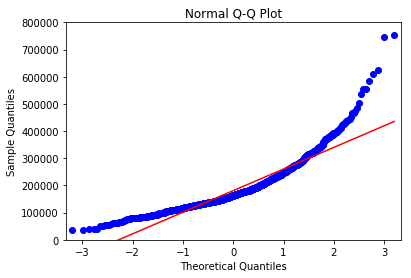

In [124]:
qq_saleprice = houses['SalePrice'][houses['SalePrice'].notnull()]
sm.qqplot(qq_saleprice, line='s')
plt.title("Normal Q-Q Plot")
plt.ylim(0, 800000)
pylab.show()

The skewness of 1.88 indicates a highly right skewed distribution and the Q-Q plot show that sale prices are also not normally distributed. In order to fix this, we'll take the log of SalePrice, but this time not using the "+1" as there are no 0's.

In [125]:
houses['SalePrice'] = houses['SalePrice'].apply(lambda x: np.log(x))
houses['SalePrice'].skew()

0.12156821443518162

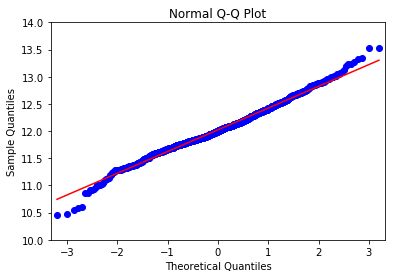

In [126]:
qq_saleprice = houses['SalePrice'][houses['SalePrice'].notnull()]
sm.qqplot(qq_saleprice, line='s')
plt.title("Normal Q-Q Plot")
plt.ylim(10, 14)
pylab.show()

### Getting back train and test sets

In [127]:
train_final = houses.iloc[:1458, :]
test_final = houses.iloc[1458:, :]
print(train_final.shape)
print(test_final.shape)

(1458, 148)
(1459, 148)


## Modeling using Linear Regression Model

As we finished the data preparation step, we'll advance to modeling. Our strategy will be using three different variations of Linear Regression with regularization: Ridge, Lasso and Elastic Net. Lasso shrinks coefficients to zero and is robust to outliers, while Ridge reduces effects of multicollinearity. Combining both gives Elastic Net.

In [128]:
train_features = train_final[train_final.columns.drop('SalePrice')]
train_target = train_final['SalePrice']
test_features = test_final[test_final.columns.drop('SalePrice')]
print(train_features.shape)
print(train_target.shape)
print(test_features.shape)

(1458, 147)
(1458,)
(1459, 147)


In [129]:
houses.head()

,LotArea,Street,LotShape,LandContour,LandSlope,Neighborhood,OverallQual,OverallCond,YearBuilt,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSSubClass_20,MSSubClass_30,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Inside,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition2_Norm,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofMatl_CompShg,RoofMatl_Tar&Grv,Exterior1st_AsbShng,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Heating_GasA,Heating_GasW,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HouseAge,Remodeled,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalBathrooms,TotalSqFeet
0,-0.101744,1,3,1,2,2,0.649468,-0.507416,1.047051,1,1.209120,4,3,5,4,3,1,6,0.601171,1,-0.363183,-0.934299,5,1,4,1.210266,-0.116953,0.570119,1.089758,-0.251841,0.783102,1.233453,0.169958,-0.20055,4,7,-0.924604,0.352265,2,-0.944279,0.834430,-0.427645,-0.112794,-0.309207,-0.064071,-0.189364,12.247694,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,-0.887744,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.589636,0.173208
1,0.149410,1,3,1,2,2,-0.061413,2.186999,0.155579,0,-0.805684,3,3,3,4,3,4,5,1.213637,1,-0.363183,-0.629460,5,1,4,-0.784504,-0.116953,-0.369466,-0.819285,3.886596,0.783102,-0.755481,0.169958,-0.20055,3,7,0.626328,-0.057831,2,1.254877,-1.082484,-0.427645,-0.112794,-0.309207,-0.064071,-0.189364,12.109011,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0.356886,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.350494,0.120042
2,0.461603,1,2,1,2,2,0.649468,-0.507416,0.981016,1,1.136870,4,3,5,4,3,2,6,0.105794,1,-0.363183,-0.288223,5,1,4,1.238295,-0.116953,0.704626,1.089758,-0.251841,0.783102,1.233453,0.169958,-0.20055,4,7,0.626328,0.631875,2,-0.944279,0.664466,-0.427645,-0.112794,-0.309207,-0.064071,-0.189364,12.317167,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,-0.839874,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.589636,0.344350
3,0.139131,1,2,1,2,2,0.649468,-0.507416,-1.858487,0,-0.805684,3,3,2,3,4,1,5,-0.502169,1,-0.363183,-0.047081,4,1,4,0.981358,-0.116953,0.582755,1.089758,-0.251841,-1.026969,-0.755481,0.169958,-0.20055,4,7,0.626328,0.790321,2,-0.944279,0.581939,2.737273,-0.112794,-0.309207,-0.064071,-0.189364,11.849398,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,

### Ridge

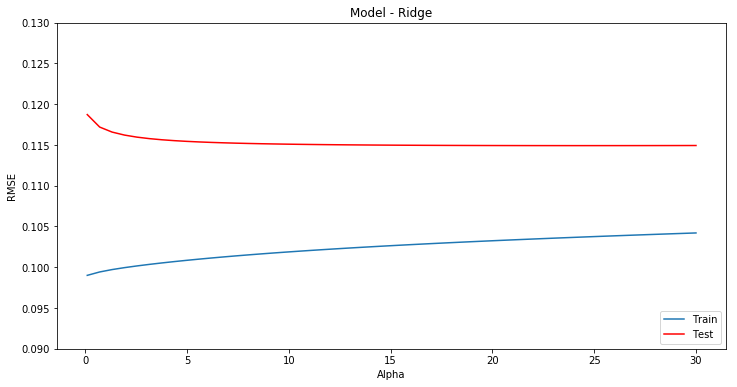

In [130]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)
alphas_ridge = np.linspace(0.1, 30, 50)
rid_train_score_list = []
rid_test_score_list = []
for a in alphas_ridge:
    model = Ridge(alpha=a)
    rid = cross_validate(model, train_features, train_target,
                         scoring='neg_mean_squared_error', cv=kf, return_train_score=True)
    rid_train_mean = (abs(np.mean(rid['train_score'])))**0.5
    rid_test_mean = (abs(np.mean(rid['test_score'])))**0.5
    rid_train_score_list.append(rid_train_mean)
    rid_test_score_list.append(rid_test_mean)
    
plt.figure(figsize=(12,6))
plt.plot(alphas_ridge, rid_train_score_list, label='Train')
plt.plot(alphas_ridge, rid_test_score_list, c='red', label='Test')
plt.ylim(0.09, 0.13)
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.title("Model - Ridge")
plt.legend(loc="lower right")
plt.show()

### Lasso

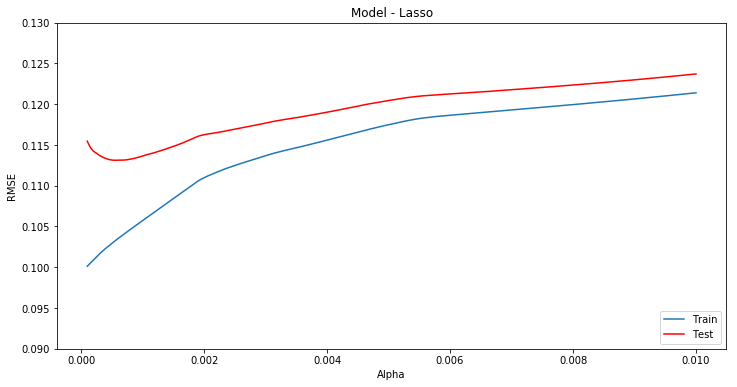

In [131]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)
alphas_lasso = np.arange(0.0001, 0.01005, 0.00005)
lasso_train_score_list = []
lasso_test_score_list = []
for a in alphas_lasso:
    model = Lasso(alpha=a)
    lasso = cross_validate(model, train_features, train_target,
                           scoring='neg_mean_squared_error', cv=kf,
                           return_train_score=True)
    lasso_train_mean = (abs(np.mean(lasso['train_score'])))**0.5
    lasso_test_mean = (abs(np.mean(lasso['test_score'])))**0.5
    lasso_train_score_list.append(lasso_train_mean)
    lasso_test_score_list.append(lasso_test_mean)
    
plt.figure(figsize=(12,6))
plt.plot(alphas_lasso, lasso_train_score_list, label='Train')
plt.plot(alphas_lasso, lasso_test_score_list, c='red', label='Test')
plt.ylim(0.09, 0.13)
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.title("Model - Lasso")
plt.legend(loc="lower right")
plt.show()

### Elastic Net

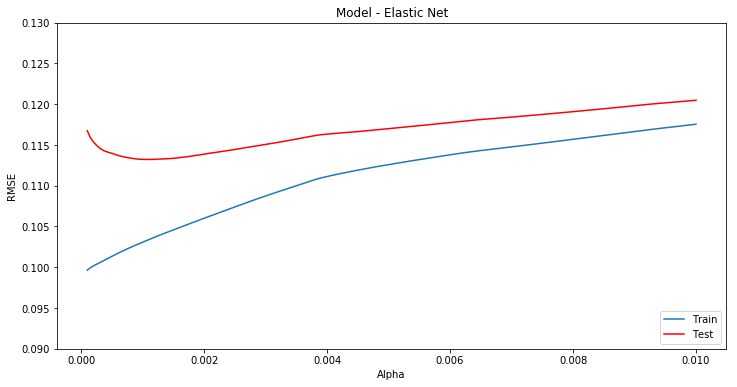

In [132]:
# Let's consider the l1_ratio being default, i.e., 0.5
kf = KFold(n_splits=5, shuffle=True, random_state=123)
alphas_en = np.arange(0.0001, 0.01005, 0.00005)
en_train_score_list = []
en_test_score_list = []
for a in alphas_en:
    model = ElasticNet(alpha=a, max_iter=5000)
    en = cross_validate(model, train_features, train_target,
                         scoring='neg_mean_squared_error', cv=kf, return_train_score=True)
    en_train_mean = (abs(np.mean(en['train_score'])))**0.5
    en_test_mean = (abs(np.mean(en['test_score'])))**0.5
    en_train_score_list.append(en_train_mean)
    en_test_score_list.append(en_test_mean)
    
plt.figure(figsize=(12,6))
plt.plot(alphas_en, en_train_score_list, label='Train')
plt.plot(alphas_en, en_test_score_list, c='red', label='Test')
plt.ylim(0.09, 0.13)
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.title("Model - Elastic Net")
plt.legend(loc="lower right")
plt.show()

### Best Results for each model

In [133]:
best_rid = rid_test_score_list.index(min(rid_test_score_list))
best_lasso = lasso_test_score_list.index(min(lasso_test_score_list))
best_en = en_test_score_list.index(min(en_test_score_list))

print("RIDGE:")
print("Train RMSE:", rid_train_score_list[best_rid])
print("Test RMSE:", rid_test_score_list[best_rid])
print("Best Alpha:", alphas_ridge[best_rid])
print("-"*20)
print("LASSO:")
print("Train RMSE:", lasso_train_score_list[best_lasso])
print("Test RMSE:", lasso_test_score_list[best_lasso])
print("Best Alpha:", alphas_lasso[best_lasso])
print("-"*20)
print("ELASTIC NET:")
print("Train RMSE:", en_train_score_list[best_en])
print("Test RMSE:", en_test_score_list[best_en])
print("Best Alpha:", alphas_en[best_en])

RIDGE:
Train RMSE: 0.10371444865029238
Test RMSE: 0.11491777256587651
Best Alpha: 24.508163265306123
--------------------
LASSO:
Train RMSE: 0.10322705784528916
Test RMSE: 0.11312204893712278
Best Alpha: 0.0005500000000000001
--------------------
ELASTIC NET:
Train RMSE: 0.10338669464322305
Test RMSE: 0.11321824177834117
Best Alpha: 0.0011000000000000003


The best result we had was using the **Lasso model: Test RMSE = 0.1131**. Also, it has a little distance from the Train RMSE (0.1032), which indicates that the model isn't suffering overfitting. Now, let's fit our model and get predictions on the test set.

In [134]:
# Shuffling the train set
np.random.seed(123)
train_final = train_final.reindex(np.random.permutation(train_final.index))
train_features_shuf = train_final[train_final.columns.drop('SalePrice')]
train_target_shuf = train_final['SalePrice']

# Fitting the model into the train set and getting predictions to test set
model = Lasso(alpha=alphas_lasso[best_lasso])
model.fit(train_features_shuf, train_target_shuf)
predictions = model.predict(test_features)
predictions = np.exp(predictions)
predictions

array([125533.11064366, 161701.77654132, 182645.23310078, ...,
       163370.50550659, 116769.67747312, 217669.07736684])

In [135]:
results_df = pd.DataFrame(data={'Id': test['Id'].values, 'SalePrice': predictions}, index=test['Id'].values, columns=['Id', 'SalePrice'])
results_df.index = results_df.index.rename('index')
results_df.head()

,Id,SalePrice
index,,
1461,1461,125533.110644
1462,1462,161701.776541
1463,1463,182645.233101
1464,1464,201469.757653
1465,1465,194917.820674


In [136]:
results_df.to_csv('submission.csv', index=False)

# Next Steps

We reached good results with all the steps we took in feature engineering, feature selection and modeling. However, in order to improve the error of the model there are possibly few more steps to do:

- Do not drop columns with more than 5% of missing data and actually treat them;
- Handle better the Porch columns;
- Mix prediction results from the three different models;
- Create polinomial features.